# Import Dependencies

In [ ]:
import scipy
import tensorflow as tf
import os
import sys
import time
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
import glob
from tqdm import tqdm
import cv2 as cv
from IPython import display
from google.colab import files
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.layers import \
            Input, Dense, Reshape, Flatten, Dropout, \
            Concatenate, concatenate, BatchNormalization, Activation, \
            ZeroPadding2D, LeakyReLU,ReLU,UpSampling2D, \
            Conv2D,Conv2DTranspose
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet_v2 import ResNet50V2
from skimage.transform import resize

In [ ]:
#Download and Inspect Dataset

path = '/content/sketch_to_photo'
train_sketch_url = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_sketches.zip'
train_photo_url = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_photos.zip'
test_sketch_url = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Cropped_Images/CUHK_testing_cropped_sketches.zip'
test_photo_url = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Cropped_Images/CUHK_testing_cropped_photos.zip'

In [ ]:
!mkdir sketch_to_photo

mkdir: cannot create directory ‘sketch_to_photo’: File exists


In [ ]:
path_to_train_sketch_zip = tf.keras.utils.get_file(path+'/train/CUHK_training_cropped_sketches.zip',
                                      origin=train_sketch_url,archive_format='zip',
                                       cache_subdir=path+'/train',
                                      extract=True)

path_to_train_photo_zip = tf.keras.utils.get_file(path+'/train/CUHK_training_cropped_photos.zip',
                                      origin=train_photo_url,archive_format='zip',
                                       cache_subdir=path+'/train',
                                      extract=True)

path_to_test_sketch_zip = tf.keras.utils.get_file(path+'/test/CUHK_testing_cropped_sketches.zip',
                                       cache_subdir=path+'/test',
                                      origin=test_sketch_url,
                                      extract=True)

path_to_test_photo_zip = tf.keras.utils.get_file(path+'/test/CUHK_testing_cropped_photos.zip',
                                      origin=test_photo_url,
                                       cache_subdir=path+'/test',
                                      extract=True)

In [ ]:
path_to_train_sketch = os.path.join(os.path.dirname(path_to_train_sketch_zip), 'sketches/')
path_to_train_photo = os.path.join(os.path.dirname(path_to_train_photo_zip), 'photos/')
path_to_test_sketch = os.path.join(os.path.dirname(path_to_test_sketch_zip), 'sketches/')
path_to_test_photo = os.path.join(os.path.dirname(path_to_test_photo_zip), 'photos/')

In [ ]:
def load_sketch_photo(sketch_image_file, original_image):
  sketch = tf.io.read_file(sketch_image_file)
  sketch = tf.image.decode_jpeg(sketch,channels=3)

  photo = tf.io.read_file(original_image)
  photo = tf.image.decode_jpeg(photo,channels=3)

  sketch = tf.cast(sketch, tf.float32)
  photo = tf.cast(photo, tf.float32)

  return sketch, photo

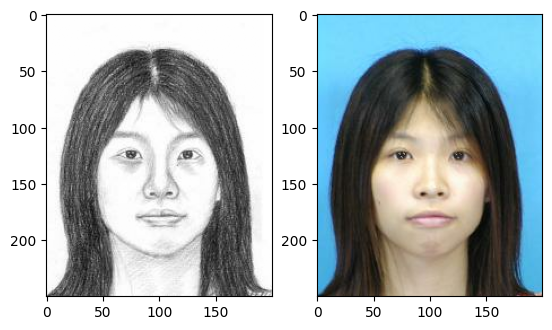

In [ ]:
example_sketch, example_photo = load_sketch_photo(path_to_train_sketch+'F2-005-01-sz1.jpg', path_to_train_photo+'f-005-01.jpg')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow((example_sketch/127.5-1) * 0.5 + 0.5)
ax2.imshow((example_photo/127.5-1) * 0.5 + 0.5)

In [ ]:
print(example_sketch.shape)
print(example_photo.shape)

(250, 200, 3)
(250, 200, 3)


In [ ]:
# Load Dataset

def load_image(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.cast(image, tf.float32)
  return image

In [ ]:
train_sketch = glob.glob(path_to_train_sketch+"/*")
train_photo = glob.glob(path_to_train_photo+"/*")
test_sketch = glob.glob(path_to_test_sketch+"/*")
test_photo = glob.glob(path_to_test_photo+"/*")

In [ ]:
train_sketch = sorted(train_sketch)
train_photo = sorted(train_photo)
test_sketch = sorted(test_sketch)
test_photo = sorted(test_photo)

In [ ]:
train_data_sketch = tf.data.Dataset.list_files(train_sketch, shuffle=False).map(load_image)
train_data_photo = tf.data.Dataset.list_files(train_photo, shuffle=False).map(load_image)
test_data_sketch = tf.data.Dataset.list_files(test_sketch, shuffle=False).map(load_image)
test_data_photo = tf.data.Dataset.list_files(test_photo, shuffle=False).map(load_image)

train_dataset = tf.data.Dataset.zip((train_data_sketch, train_data_photo))
test_dataset = tf.data.Dataset.zip((test_data_sketch, test_data_photo))

In [ ]:
# Preprocessing

def resize_image(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width])
  real_image = tf.image.resize(real_image, [height, width])

  return input_image, real_image


In [ ]:
def normalize(input_image, real_image):
  if not (tf.keras.backend.max(input_image))<=1:
    input_image = (input_image / 127.5) - 1
    # input_image = (input_image / 255)
  if not (tf.keras.backend.max(real_image))<=1:
    real_image = (real_image / 127.5) - 1
    # real_image = (real_image / 255)

  return input_image, real_image

In [ ]:
def rgb_to_gray(input_image, real_image):
  # input_image = tf.image.rgb_to_grayscale(input_image)
  real_image = tf.image.rgb_to_grayscale(real_image)

  return input_image, real_image

In [ ]:
def saturation(input_image, real_image, lower, upper, seed):
  # input_image = tf.image.random_saturation(input_image, lower, upper, seed=seed)
  real_image = tf.image.random_saturation(real_image, lower, upper, seed=seed)

  return input_image, real_image

In [ ]:
def brightness(input_image, real_image, delta, seed):
  input_image = tf.image.random_brightness(input_image, delta, seed=seed)
  real_image = tf.image.random_brightness(real_image, delta, seed=seed)

  return input_image, real_image

In [ ]:
def noise(input_image, real_image, mean, stddev):
  # input_image = input_image + tf.random.normal(tf.shape(input_image), mean=mean, stddev=stddev)
  # input_image = tf.image.convert_image_dtype(input_image, tf.float32)
  real_image = real_image + tf.random.normal(tf.shape(real_image), mean=mean, stddev=stddev)
  real_image = tf.image.convert_image_dtype(real_image, tf.float32)

  return input_image, real_image

In [ ]:
def quality(input_image, real_image, seed, min_jpeg_quality, max_jpeg_quality):
  # input_image = tf.image.random_jpeg_quality(input_image, min_jpeg_quality, max_jpeg_quality, seed=seed)
  # input_image = tf.image.convert_image_dtype(input_image, tf.float32)
  real_image = tf.image.random_jpeg_quality(real_image, min_jpeg_quality, max_jpeg_quality, seed=seed)
  real_image = tf.image.convert_image_dtype(real_image, tf.float32)

  return input_image, real_image

In [ ]:
def transformations(input_image, real_image, training_data=True):
  seed = 1

  input_image, real_image = resize_image(input_image, real_image, 256, 256)
  input_image, real_image = normalize(input_image, real_image)

  if(training_data):
    # input_image, real_image = saturation(input_image, real_image, 0.95, 1, seed)
    input_image, real_image = brightness(input_image, real_image, 0.2, seed)
    # input_image, real_image = quality(input_image, real_image, seed, 95, 100)
    input_image, real_image = noise(input_image, real_image, 0.1, 0.1)
    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)
    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_up_down(input_image)
      real_image = tf.image.flip_up_down(real_image)


  return input_image, real_image

<Figure size 600x600 with 0 Axes>

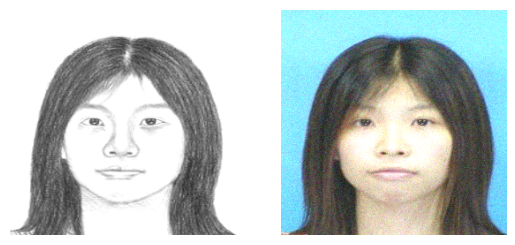

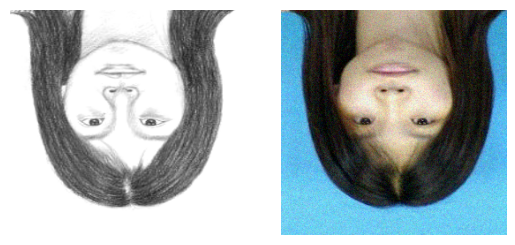

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(2):
  transformed_example_sketch, transformed_example_photo = transformations(example_sketch, example_photo)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.axis('off')
  ax2.axis('off')
  ax1.imshow(transformed_example_sketch * 0.5 + 0.5)
  ax2.imshow(transformed_example_photo * 0.5 + 0.5)
plt.show()

In [ ]:
BATCH_SIZE = 1
BUFFER_SIZE = 400

apply_train = lambda x, y: transformations(x, y)
apply_test = lambda x, y: transformations(x, y, training_data=False)
train_dataset = train_dataset.map(apply_test).concatenate(train_dataset.map(apply_train))
test_dataset = test_dataset.map(apply_test)

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Generative Adversarial Network

In [ ]:
# Utils

class ModelUtils:

  @staticmethod
  def generator_loss(disc_generated_output, gen_output, target, loss_object, LAMBDA=100):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

  @staticmethod
  def discriminator_loss(disc_real_output, disc_generated_output, loss_object):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

  @staticmethod
  def generate_images(generator, test_input, tar, training=True, show_images=False):
    prediction = generator(test_input, training=training)

    if show_images:
      plt.figure(figsize=(15,15))

      display_list = [test_input[0], tar[0], prediction[0]]
      title = ['Input Image', 'Ground Truth', 'Predicted Image']

      for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
      plt.show()

  @staticmethod
  def save_model(model, path, name, model_type="generator"):
    tf.saved_model.save(model, os.path.join(path, name, model_type))

  @staticmethod
  def load_model(path, name, model_type="generator"):
    return tf.saved_model.load(os.path.join(path, name, model_type))

  @staticmethod
  def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

  @staticmethod
  def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result


# Generator

In [ ]:
# SimpleGenerator

class SimpleGenerator:

  @staticmethod
  def build_model(input_shape, output_channels=3, initializer=tf.random_normal_initializer(0., 0.02)):
    inputs = Input(shape=input_shape)


    down_stack = [
      ModelUtils.downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
      ModelUtils.downsample(128, 4), # (bs, 64, 64, 128)
      ModelUtils.downsample(256, 4), # (bs, 32, 32, 256)
      ModelUtils.downsample(512, 4), # (bs, 16, 16, 512)
      ModelUtils.downsample(512, 4), # (bs, 8, 8, 512)
      ModelUtils.downsample(512, 4), # (bs, 4, 4, 512)
      ModelUtils.downsample(512, 4), # (bs, 2, 2, 512)
      ModelUtils.downsample(512, 4), # (bs, 1, 1, 512)
    ]
    up_stack = [
      ModelUtils.upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
      ModelUtils.upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
      ModelUtils.upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
      ModelUtils.upsample(512, 4), # (bs, 16, 16, 1024)
      ModelUtils.upsample(256, 4), # (bs, 32, 32, 512)
      ModelUtils.upsample(128, 4), # (bs, 64, 64, 256)
      ModelUtils.upsample(64, 4), # (bs, 128, 128, 128)
    ]

    last = Conv2DTranspose(output_channels, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh') # (bs, 256, 256, 3)

    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
      x = down(x)
      skips.append(x)
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      x = Concatenate()([x, skip])
    x = last(x)

    return Model(inputs=inputs, outputs=x)


class Discriminator:

  @staticmethod
  def build_model_boh(input_shape, initializer=tf.random_normal_initializer(0.0, 0.02)):
    inputs = Input(shape=input_shape)
    targets = Input(shape=input_shape)

    x = concatenate([inputs, targets])



  @staticmethod
  def build_model_patchgan(input_shape, initializer=tf.random_normal_initializer(0., 0.02)):

    inp = Input(shape=input_shape, name='input_image')
    tar = Input(shape=input_shape, name='target_image')

    x = concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = ModelUtils.downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = ModelUtils.downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = ModelUtils.downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    last = Flatten()(last)
    last = Dense(1 ,activation="sigmoid")(last)

    return Model(inputs=[inp, tar], outputs=last)


In [ ]:
# XceptionGenerator

class XceptionGenerator:

  @staticmethod
  def build_model(input_shape, output_channels=3, initializer=tf.random_normal_initializer(0., 0.02)):

    xception = Xception(weights='imagenet',include_top=False, input_shape=(256, 256, 3))

    layer_names = [
          'block13_sepconv2_bn',
          'block13_pool'
    ]
    layers = [xception.get_layer(name).output for name in layer_names]
    down_stack = Model(inputs=xception.input, outputs=layers)
    down_stack.trainable = False

    up_stack = [
          ModelUtils.upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
          ModelUtils.upsample(512, 4, apply_dropout=True)   # (bs, 16, 16, 1024)
    ]

    inputs = Input(shape=input_shape)
    last = Conv2DTranspose(output_channels, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh') # (bs, 256, 256, 3)

    x = inputs
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      x = Concatenate()([x, skip])

    x = ModelUtils.upsample(512, 4)(x)
    x = ModelUtils.upsample(256, 4)(x)
    x = ModelUtils.upsample(128, 4)(x)
    x = last(x)

    return Model(inputs=inputs, outputs=x)


In [ ]:
# ResnetGenerator


class ResnetGenerator:

  @staticmethod
  def build_model(input_shape, output_channels=3, initializer=tf.random_normal_initializer(0., 0.02)):

    resnet = ResNet50V2(weights='imagenet',include_top=False, input_shape=(256, 256, 3))

    layer_names = [
          'conv1_conv',   # (128 128 64)
          'conv3_block1_preact_relu', # (32 32 256)
          'conv4_block1_preact_relu', # (16 16 512)
          # 'conv5_block1_2_relu', # (8 8 512)
          'conv5_block3_2_relu', # (8 8 512)
    ]
    layers = [resnet.get_layer(name).output for name in layer_names]
    down_stack = Model(inputs=resnet.input, outputs=layers)
    down_stack.trainable = False

    up_stack = [
          ModelUtils.upsample(512, 4, apply_dropout=True),

          ModelUtils.upsample(256, 4),
          ]

    inputs = Input(shape=input_shape)

    last = Conv2DTranspose(output_channels, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh') # (bs, 256, 256, 3)

    x = inputs
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    # set_trace()
    for up, skip in zip(up_stack, skips):
      x = up(x)
      x = Concatenate()([x, skip])

    x = ModelUtils.upsample(128, 4)(x)
    x = ModelUtils.upsample(64, 4)(x)
    x = Concatenate()([x, list(skips)[0]])
    x = last(x)
    return Model(inputs=inputs, outputs=x)


In [ ]:
# MobileNetGenerator

class MobileNetGenerator:

  @staticmethod
  def build_model(input_shape, output_channels=3, initializer=tf.random_normal_initializer(0., 0.02)):

    base_model = MobileNetV2(input_shape=[256, 256, 3], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',
        'block_3_expand_relu',
        'block_6_expand_relu',
        'block_13_expand_relu',
        'block_16_project',
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = Model(inputs=base_model.input, outputs=layers)
    down_stack.trainable = False

    up_stack = [
        ModelUtils.upsample(512, 3),
        ModelUtils.upsample(256, 3),
        ModelUtils.upsample(128, 3),
        ModelUtils.upsample(64, 3),
    ]


    inputs = Input(shape=input_shape)

    last = Conv2DTranspose(output_channels, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')

    x = inputs
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      x = Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)


In [ ]:
# Discriminator

class Discriminator:

  @staticmethod
  def build_model(input_shape, initializer=tf.random_normal_initializer(0., 0.02)):

    inp = Input(shape=input_shape, name='input_image')
    tar = Input(shape=input_shape, name='target_image')

    x = concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = ModelUtils.downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = ModelUtils.downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = ModelUtils.downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return Model(inputs=[inp, tar], outputs=last)

# GAN

In [ ]:
class GANModels:

  def __init__(self, gen_optimizer, disc_optimizer, model_name, generator, discriminator, log_dir='logs', model_dir='models', out_channels=3):
    self.generator_model = generator
    self.discriminator_model = discriminator
    self.generator_optimizer = gen_optimizer
    self.discriminator_optimizer = disc_optimizer
    self.output_channels = out_channels
    self.model_name = model_name
    self.summary_writer = tf.summary.create_file_writer(os.path.join(log_dir, model_name))
    self.log_dir = log_dir
    self.model_dir = model_dir
    self.total_epochs = 0
    self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                    discriminator_optimizer=self.discriminator_optimizer,
                                    generator=self.generator_model,
                                    discriminator=self.discriminator_model)

  def get_generator_model(self):
    return self.generator_model

  def get_discriminator_model(self):
    return self.discriminator_model

  def get_optimizers(self):
    return self.generator_optimizer, self.discriminator_optimizer

  def get_model_name(self):
    return self.model_name

  def save_model(self):
    tf.saved_model.save(self.generator_model, self.model_dir +"/"+self.model_name+"/generator")
    tf.saved_model.save(self.discriminator_model, self.model_dir +"/"+self.model_name+"/discriminator")

  def load_model(self):
    self.generator_model = tf.saved_model.load(self.model_dir +"/"+self.model_name+"/generator")
    self.discriminator_model = tf.saved_model.load(self.model_dir +"/"+self.model_name+"/discriminator")

  @tf.function
  def train_step(self, input_image, target, epoch):
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_output = self.generator_model(input_image, training=True)
      disc_real_output = self.discriminator_model([input_image, target], training=True)
      disc_generated_output = self.discriminator_model([input_image, gen_output], training=True)
      gen_total_loss, gen_gan_loss, gen_l1_loss = ModelUtils.generator_loss(disc_generated_output, gen_output, target, loss_object)
      disc_loss = ModelUtils.discriminator_loss(disc_real_output, disc_generated_output, loss_object)

    discriminator_gradients = disc_tape.gradient(disc_loss, self.discriminator_model.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator_model.trainable_variables))

    generator_gradients = gen_tape.gradient(gen_total_loss, self.generator_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, self.generator_model.trainable_variables))


    with self.summary_writer.as_default():
      tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
      tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
      tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
      tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_output


  def fit(self, train_ds, epochs, test_ds, checkpoint_prefix, show_progress=False):
    for epoch in tqdm(range(epochs)):

      display.clear_output(wait=True)

      start = time.time()

      if show_progress:
        for example_input, example_target in test_ds.take(1):
          ModelUtils.generate_images(self.generator_model, example_input, example_target,
                                     training=False, show_images=show_progress)
      print("Epoch: ", epoch)

      for (input_image, target) in train_ds:
        #print("Working on a batch...")
        generated = self.train_step(input_image, target, epoch)

      # saving (checkpoint) the model every  x epochs
      if (epoch + 1) % 20 == 0:
        self.checkpoint.save(file_prefix = checkpoint_prefix)

      print('\nTime taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

    # saving (checkpoint) the model just at the end
    self.checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
# Create and Train GAN

input_shape = [256,256,3]
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
EPOCHS = 400
checkpoint_prefix = "/content/sketch_to_photo/checkpoints/"
log_dir = "/content/sketch_to_photo/logs/"
model_dir = "/content/sketch_to_photo/models/"

Train modelResnet50

In [ ]:
generatorResnet = ResnetGenerator.build_model(input_shape)
discriminatorResnet = Discriminator.build_model(input_shape)
modelResnet = GANModels(generator_optimizer, discriminator_optimizer, "modelResnet",
                           generatorResnet, discriminatorResnet, log_dir, model_dir)
modelResnet.fit(train_dataset, 6, test_dataset, checkpoint_prefix, show_progress=False)

Epoch:  5


100%|██████████| 6/6 [01:24<00:00, 14.09s/it]


Time taken for epoch 6 is 12.034900426864624 sec



Train modelMobileNet

In [ ]:
generatorMobileNet = MobileNetGenerator.build_model(input_shape)
discriminatorMobileNet = Discriminator.build_model(input_shape)
modelMobileNet = GANModels(generator_optimizer, discriminator_optimizer, "modelMobileNet",
                           generatorMobileNet, discriminatorMobileNet, log_dir, model_dir)
modelMobileNet.fit(train_dataset, EPOCHS, test_dataset, checkpoint_prefix, show_progress=False)

Train modelXception

In [ ]:
generatorXception = XceptionGenerator.build_model(input_shape)
discriminatorXception = Discriminator.build_model(input_shape)
modelXception = GANModels(generator_optimizer, discriminator_optimizer, "modelXception",
                          generatorXception, discriminatorXception, log_dir, model_dir)
modelXception.fit(train_dataset, EPOCHS, test_dataset, checkpoint_prefix, show_progress=False)

Train Pix2Pix

In [ ]:
generatorSimple = SimpleGenerator.build_model(input_shape)
discriminatorSimple = Discriminator.build_model(input_shape)
modelSimple = GANModels(generator_optimizer, discriminator_optimizer, "modelSimple",
                        generatorSimple, discriminatorSimple, log_dir, model_dir)
modelSimple.fit(train_dataset, EPOCHS, test_dataset, checkpoint_prefix, show_progress=False)

Test

In [ ]:
def results(model, test_dataset):
  for inp, tar in test_dataset.take(8):
    ModelUtils.generate_images(model.get_generator_model(), inp, tar, False, True)

results(modelResnet, test_dataset)

# Results

In [ ]:
# Loading tensorboard
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir /content/sketch_to_photo/logs

In [ ]:
# MAE

def compute_mae(G, test_dataset):
  mae = 0.0
  count = 0

  for input, target in test_dataset:
    count += 1
    generated = G(input)
    mae += tf.reduce_mean(tf.abs(tf.subtract(target, generated)))

  return mae.numpy(), mae.numpy()/count

print("MAE modelResnet: ", compute_mae(modelResnet.get_generator_model(), test_dataset))

MAE modelResnet:  (19.737858, 0.19737857818603516)


# Frechet Inception Distance

In [ ]:
# Functions
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [ ]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)
	# calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real
	# calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

In [ ]:
def save_output(model, test_dataset):
  if not os.path.exists("sketch_to_photo/output/"+model.get_model_name()):
    os.makedirs("sketch_to_photo/output/"+model.get_model_name()+"/real")
    os.makedirs("sketch_to_photo/output/"+model.get_model_name()+"/generated")
    os.makedirs("sketch_to_photo/output/"+model.get_model_name()+"/sketch")
  for index, (inp, tar) in enumerate(tqdm(test_dataset.take(len(test_dataset))), start=1):
    generated_photo = model.get_generator_model()(inp, training=False)[0]
    tar = np.squeeze(tar)
    inp = np.squeeze(inp)
    tf.keras.preprocessing.image.save_img("/content/sketch_to_photo/output/"+str(model.get_model_name())+"/real/"+str(index)+".jpg",
                                        tar, data_format=None, file_format=None, scale=True)
    tf.keras.preprocessing.image.save_img("/content/sketch_to_photo/output/"+str(model.get_model_name())+"/generated/"+str(index)+".jpg",
                                        generated_photo, data_format=None, file_format=None, scale=True)
    tf.keras.preprocessing.image.save_img("/content/sketch_to_photo/output/"+str(model.get_model_name())+"/sketch/"+str(index)+".jpg",
                                        inp, data_format=None, file_format=None, scale=True)


In [ ]:
def numpyimage(sketch_image_file, original_image):
  image1 = cv.imread(sketch_image_file)
  image2 = cv.imread(original_image)
  return image1, image2

def save_join(model, left, right):
  if left == "sketch":
    left = sorted(glob.glob("/content/sketch_to_photo/output/"+model.get_model_name()+"/sketch/*"))
  elif left == "real":
    letf = sorted(glob.glob("/content/sketch_to_photo/output/"+model.get_model_name()+"/real/*"))
  elif left == "generated":
    left = sorted(glob.glob("/content/sketch_to_photo/output/"+model.get_model_name()+"/generated/*"))

  if right=="sketch":
    right = sorted(glob.glob("/content/sketch_to_photo/output/"+model.get_model_name()+"/sketch/*"))
  elif right == "real":
    right = sorted(glob.glob("/content/sketch_to_photo/output/"+model.get_model_name()+"/real/*"))
  elif right == "generated":
    right = sorted(glob.glob("/content/sketch_to_photo/output/"+model.get_model_name()+"/generated/*"))

  out_dir = "/content/sketch_to_photo/output/"+model.get_model_name()+"/join/"
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  for i, (r, g) in enumerate(zip(left, right)):
    im1,im2 = numpyimage(r, g)
    im_v = cv.hconcat([im1, im2])
    cv.imwrite(out_dir+str(i)+"_merged.jpg", im_v)

In [ ]:
def load_output(model):
  real_photos = sorted(glob.glob("/content/sketch_to_photo/output/"+model.get_model_name()+"/real/*"))
  generated_photos = sorted(glob.glob("/content/sketch_to_photo/output/"+model.get_model_name()+"/generated/*"))
  real_photos = tf.data.Dataset.list_files(real_photos, shuffle=False).map(load_image)
  generated_photos = tf.data.Dataset.list_files(generated_photos, shuffle=False).map(load_image)

  return real_photos, generated_photos

In [ ]:
def fid_measure_for_data(model_inception, real_photos, generated_photos):
  real_photos = scale_images(real_photos, (299,299,3))
  generated_photos = scale_images(generated_photos, (299,299,3))
  real_photos = preprocess_input(real_photos)
  generated_photos = preprocess_input(generated_photos)
  return round(calculate_fid(model_inception, real_photos, generated_photos), 3)


# Calculate FID

In [ ]:
save_output(modelResnet, test_dataset)
save_join(modelResnet, "sketch", "generated")

100%|██████████| 100/100 [00:01<00:00, 66.70it/s]


In [ ]:
model_inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

real_photos, generated_photos = load_output(modelResnet)
fid_measure = fid_measure_for_data(model_inception, real_photos, generated_photos)
print("\nFID: ", fid_measure)


FID:  80.004


In [ ]:
# download all output files
!zip -r /content/output.zip /content/sketch_to_photo/output/
files.download("/content/output.zip")